# Sistemas Multiagentes

## Obligatorio

Mariano Chicatun. N° Estudiante: 301379 


In [2]:
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict

# Agent imports
from agents.counterfactualregret_mcts import CounterFactualRegretMCTS
from agents.mcts import MonteCarloTreeSearch
from agents.counterfactualregret import CounterFactualRegret
from agents.agent_random import RandomAgent
# Game imports
from games.kuhn3 import KuhnPoker3
from games.kuhn import KuhnPoker
from games.tictactoe import TicTacToe
from importlib import reload
import base.utils
reload(base.utils)
from base.utils import play, run, play_game

In [85]:
from collections import defaultdict

def run_simulations(game_class, agent_combinations, num_simulations=100, training_iterations=100):
    results = defaultdict(list)

    agent_tags = {
        MonteCarloTreeSearch: "MCTS",
        RandomAgent: "Rand",
        CounterFactualRegret: "CFR",
        CounterFactualRegretMCTS: "CFR+MCTS",
    }

    for agent_combo in agent_combinations:
        tag = " & ".join([agent_tags.get(agent_class, "Unknown") for agent_class in agent_combo])

        # Train agents for this combination
        trained_agents = {}
        for agent_name, agent_class in zip(game_class().agents, agent_combo):
            agent = agent_class(game=game_class(render_mode='human'), agent=agent_name)
            if hasattr(agent, 'train'):
                agent.train(niter=training_iterations)
            trained_agents[agent_name] = agent

        # Run simulations with trained agents
        for _ in range(num_simulations):
            game = game_class(render_mode='human')
            agents = {agent_name: trained_agents[agent_name] for agent_name in game.agents}

            winner, rewards, num_turns = play_game(game, agents)
            results[tag].append({'winner': winner, 'rewards': rewards, 'num_turns': num_turns})

    return dict(results)


In [65]:
# Combinaciones para 2 jugadores
agent_combinations_2p = [
    (MonteCarloTreeSearch, RandomAgent),
    (CounterFactualRegret, MonteCarloTreeSearch),
    # (CounterFactualRegretMCTS, MonteCarloTreeSearch)
]

# Combinaciones para 3 jugadores
agent_combinations_3p = [
    (MonteCarloTreeSearch, RandomAgent, CounterFactualRegret),
    (MonteCarloTreeSearch, RandomAgent, RandomAgent),
    (RandomAgent, RandomAgent, CounterFactualRegret),
]

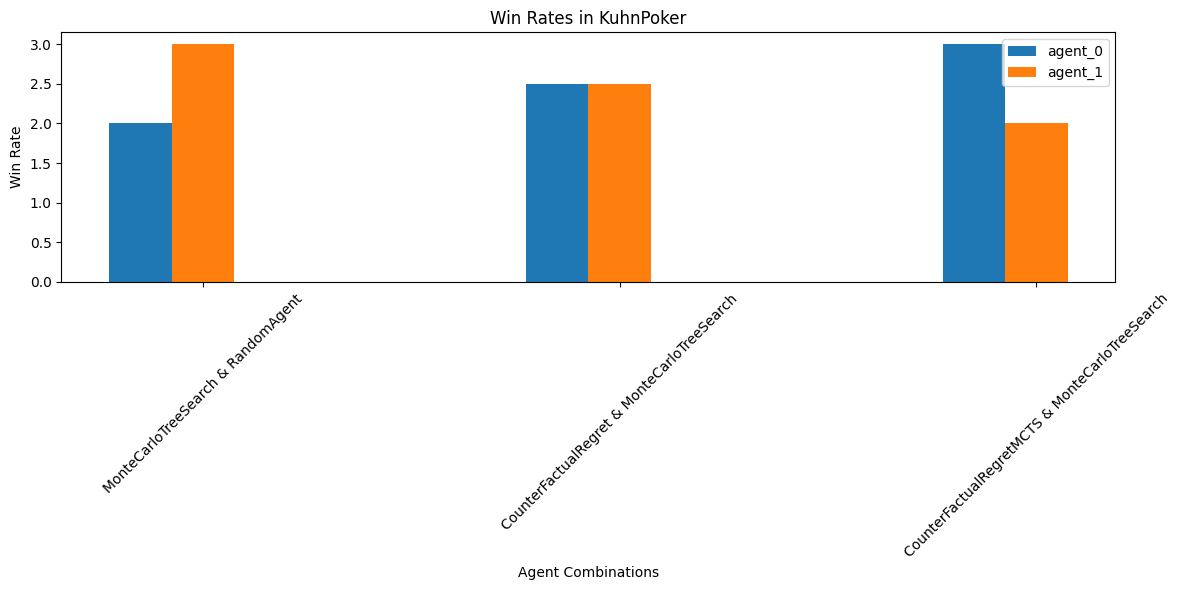

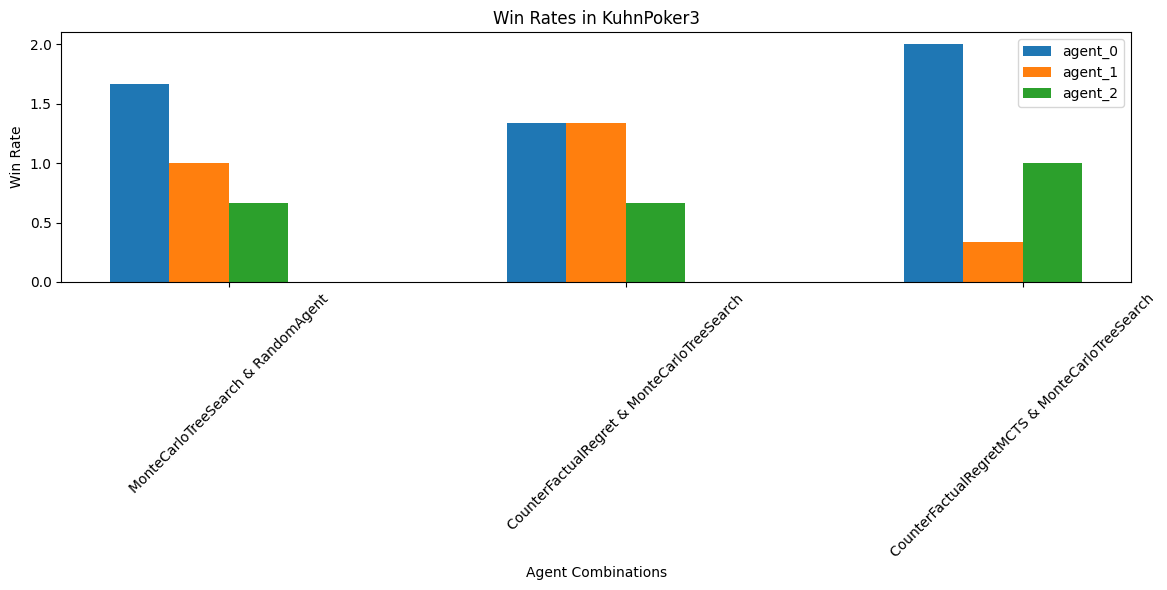

In [69]:
def plot_win_rates(simulation_data):
    # Assuming each entry in simulation_data now includes a list of winners per game
    for game_name, game_results in simulation_data.items():
        plt.figure(figsize=(12, 6))

        all_players = set()
        for agent_combination, results in game_results.items():
            for result in results['wins']:
                all_players.add(result)
        all_players = sorted(list(all_players))

        n_groups = len(game_results)
        bar_width = 0.15
        index = np.arange(n_groups)

        for i, player in enumerate(all_players):
            win_rates = []
            for agent_combination, combo_results in game_results.items():
                print()
                win_counts = combo_results['wins'][player]#list(combo_results['wins']).count(player)
                win_rate = win_counts / len(combo_results['wins'])
                win_rates.append(win_rate)

            plt.bar(index + i * bar_width, win_rates, bar_width, label=f"{player}")

        plt.title(f'Win Rates in {game_name}')
        plt.xlabel('Agent Combinations')
        plt.ylabel('Win Rate')
        plt.xticks(index + bar_width * len(all_players) / 2, game_results.keys(), rotation=45)
        plt.legend()
        plt.tight_layout()
        plt.show()
plot_win_rates(simulation_data)

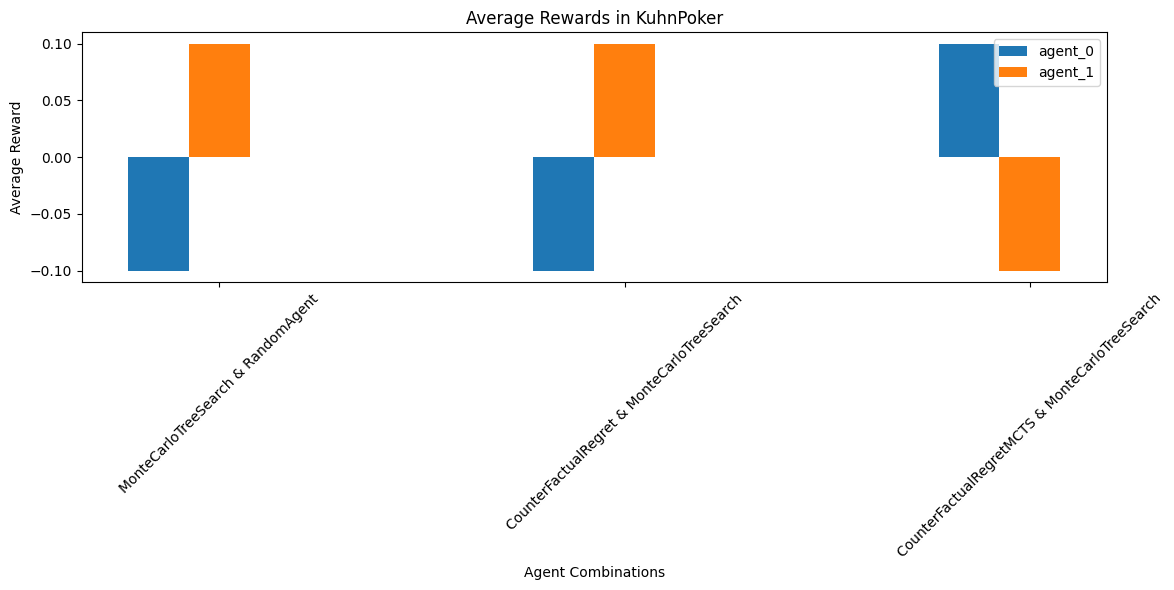

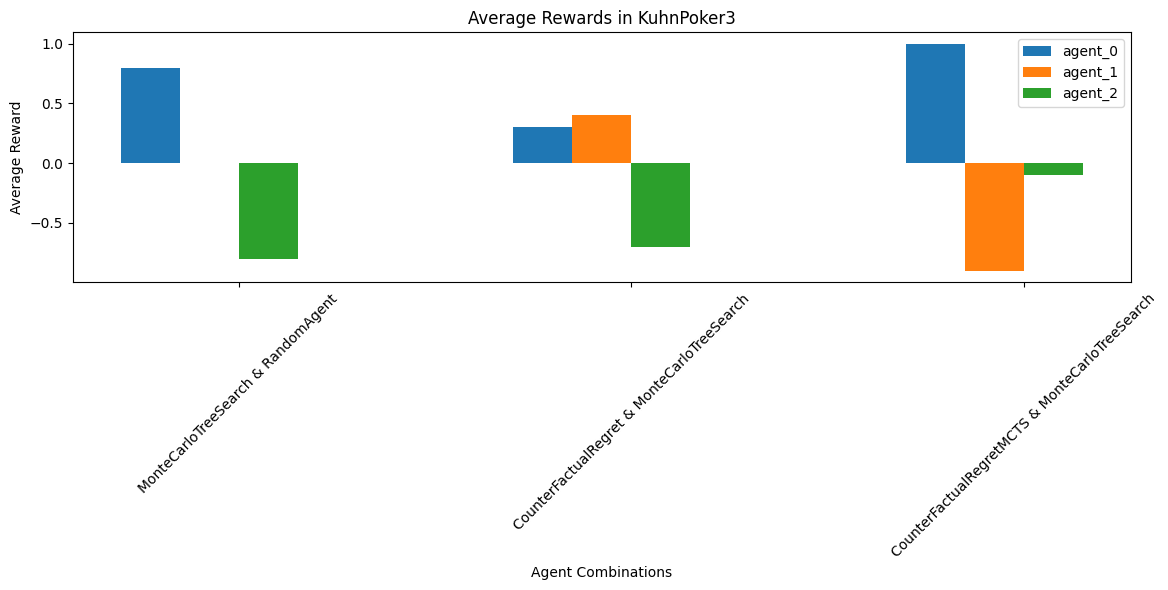

In [60]:
def plot_average_rewards(simulation_data):
    for game_name, game_results in simulation_data.items():
        plt.figure(figsize=(12, 6))
        
        # Collect all agents across agent combinations for current game
        all_agents = set()
        for combo_results in game_results.values():
            for agent in combo_results['rewards'].keys():
                all_agents.add(agent)
        all_agents = sorted(list(all_agents))
        
        n_groups = len(game_results)
        bar_width = 0.15
        index = np.arange(n_groups)

        for i, agent in enumerate(all_agents):
            avg_rewards = []
            for agent_combo, combo_results in game_results.items():
                rewards = combo_results['rewards'].get(agent, [])
                avg_reward = sum(rewards) / len(rewards) if rewards else 0
                avg_rewards.append(avg_reward)

            plt.bar(index + i * bar_width, avg_rewards, bar_width, label=f"{agent}")

        plt.title(f'Average Rewards in {game_name}')
        plt.xlabel('Agent Combinations')
        plt.ylabel('Average Reward')
        plt.xticks(index + bar_width * len(all_agents) / 2, game_results.keys(), rotation=45)
        plt.legend()
        plt.tight_layout()
        plt.show()

plot_average_rewards(simulation_data)


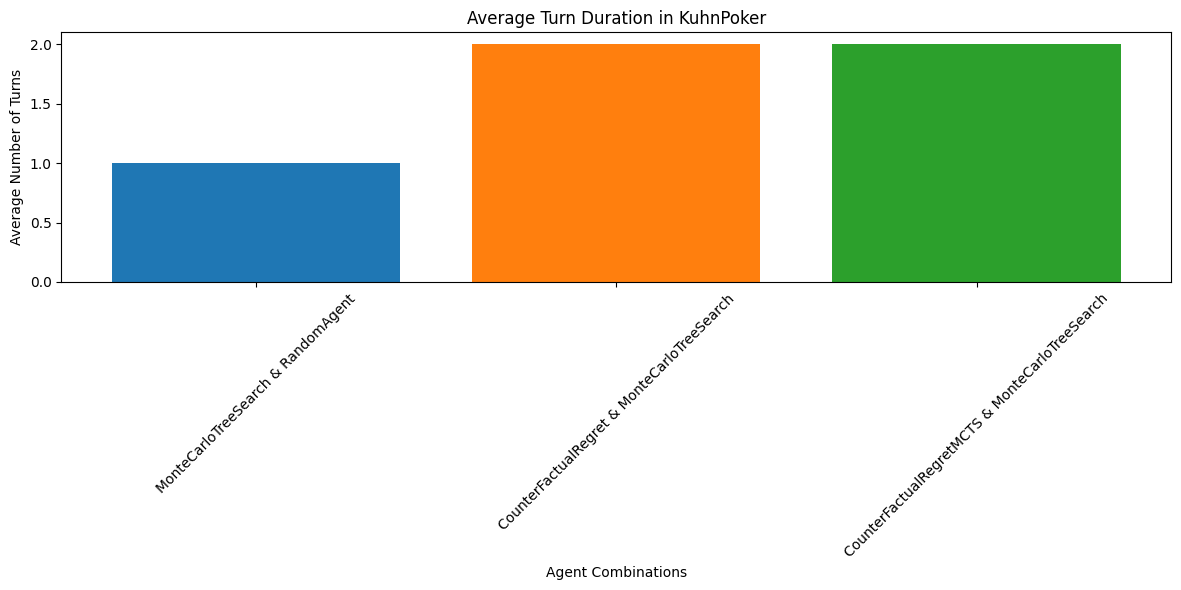

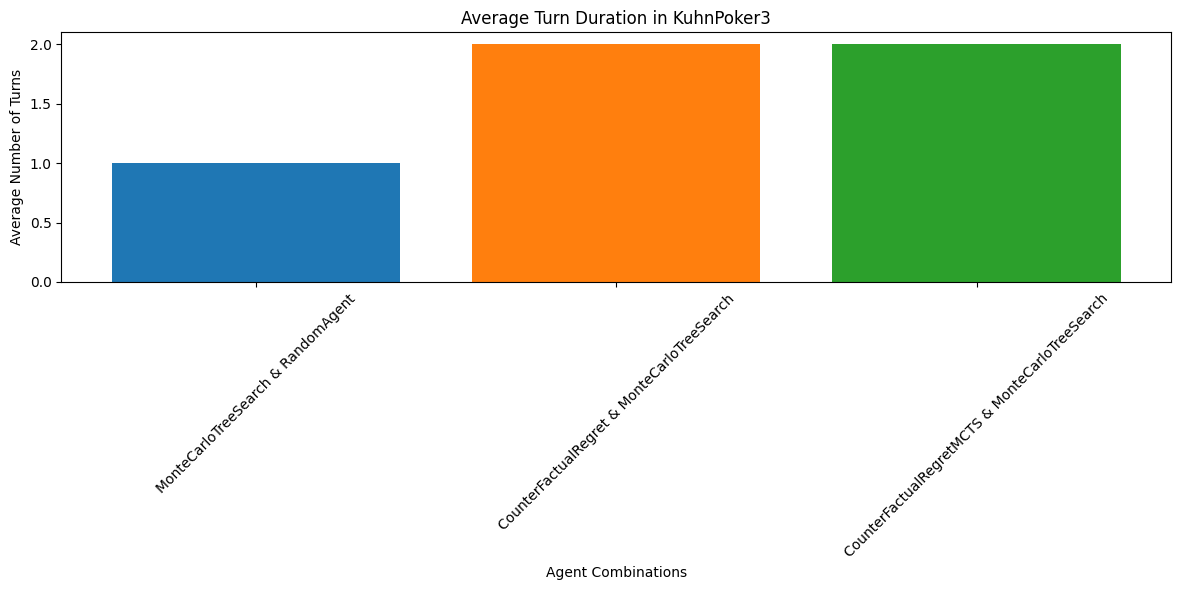

In [58]:
def plot_turn_durations(simulation_data):
    for game_name, game_results in simulation_data.items():
        plt.figure(figsize=(12, 6))
        for agent_combo, results in game_results.items():
            average_turns = sum(results['turns']) / len(results['turns'])
            plt.bar(agent_combo, average_turns)

        plt.title(f'Average Turn Duration in {game_name}')
        plt.xlabel('Agent Combinations')
        plt.ylabel('Average Number of Turns')
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()

plot_turn_durations(simulation_data)


# Conclusiones

Este proyecto me mostró la eficacia y las diferencias clave entre varios algoritmos de toma de decisiones estratégicas, como CFR y MCTS, aplicados en juegos de información imperfecta.

Algoritmo CFR: Se destacó por su habilidad en minimizar el regret contrafactual, que resulto ser mas eficiente que MCTS según lo planteado. Aunque computacionalmente intensivo, CFR parece tener una capacidad solida para mejorar estrategias a lo largo del tiempo, ajustándose a las tácticas de los oponentes.

Algoritmo MCTS: Parece ser tener una gran flexibilidad y es eficaz en la exploracion del espacio de juego. Aunque puede no ser tan preciso como el CFR en ciertas instancias, su velocidad y adaptabilidad lo hacen valioso para juegos con estructuras complejas y en situaciones donde el tiempo de respuesta es crítico.

Intente implementaciones CFR+MCTS y DeepCFR pero me falto tiempo y entendimiento mas profundo para que terminen de funcionar, principalmente DeepCFR. En CFR+MCTS me falto un paso que no entendí como hacer que es sobre la actualización de la utilidad o el uso de esta nueva estrategia en el juego especificamente.

En conclusión, mientras que CFR es excepcionalmente poderoso en juegos de suma cero y de información imperfecta, MCTS ofrece una aproximación más rápida y flexible, útil en una variedad de escenarios. La elección del algoritmo más apropiado dependerá de las características específicas del juego, la complejidad del espacio de decisión, y las limitaciones computacionales del entorno de implementación.